In [44]:
import casperfpga
import matplotlib.pyplot as plt
import time
import numpy as np

This notebook adapts the code from test_gpio_stability.py to do tests with all 11 boards.

In [56]:
#Reset the trigger counter
def reset_trigger_counter_all(brds):
        [brd.write_int("trig_debug_reset",1) for brd in brds]
        time.sleep(0.01)
        [brd.write_int("trig_debug_reset",0) for brd in brds]
        return

#reset the trigger timer
def reset_trigger_timer_all(brds):
        [brd.write_int("trig_debug_timer_reset",1) for brd in brds]
        time.sleep(0.01)
        [brd.write_int("trig_debug_timer_reset",0) for brd in brds]
        return

#set all boards to listen
def reset_to_listen_all(brds):
        [brd.write_int("reset_to_listen",0) for brd in brds]
        time.sleep(0.01)
        [brd.write_int("reset_to_listen",1) for brd in brds]
        return
    
#read the readout state value on all the boards
def read_state_value_all(brds):
        return([brd.read_int("readout_state_value") for brd in brds])

#send a trigger to one board
def trigger(board):
        #board is a casperfpga object
        board.write_int("send_trigger",0)
        time.sleep(0.01)
        board.write_int("send_trigger",1)
        return

#read the trigger counter on all the boards
def read_trigger_counter_all(brds):
        return [brd.read_int("trig_debug_trig_rec_count") for brd in brds]


def time_trigger_communication(board,brds):
        #board is the board to send the trigger to
        reset_trigger_counter_all(brds)
        reset_trigger_timer_all(brds)
        reset_to_listen_all(brds)
        initialstates=read_state_value_all(brds)
        trigger(board)
        time.sleep(0.1)
        timer_value=board.read_int("trig_debug_timer")
        counts=read_trigger_counter_all(brds)
        finalstates=read_state_value_all(brds)
        #return np.asarray([initialstate9,initialstate11,initialstate12,timer_value,count9,count11,count12,finalstate9,finalstate11,finalstate12])
        return initialstates,timer_value,counts,finalstates

In [46]:
#connect to boards and load firmware

firmware = "/home/ubuntu/kp/caltech-lwa/cr_firmware_test/gpio_pins3/outputs/gpio_pins3_2021-02-07_2206.fpg" # This version has a 1000 clock cycle pulse

brdnames = ['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']
print("Connecting to boards and loading firmware")
brds = [casperfpga.CasperFpga(n) for n in brdnames]
[brd.upload_to_ram_and_program(firmware) for brd in brds]
[print(brdnames[i],'Is connected? ', brds[i].is_connected()) for i in range(len(brds))]

Connecting to boards and loading firmware
snap01 Is connected?  True
snap02 Is connected?  True
snap03 Is connected?  True
snap04 Is connected?  True
snap05 Is connected?  True
snap06 Is connected?  True
snap07 Is connected?  True
snap08 Is connected?  True
snap09 Is connected?  True
snap10 Is connected?  True
snap11 Is connected?  True


[None, None, None, None, None, None, None, None, None, None, None]

## Tests 3/24/2022
Below, I run a test where all the boards are reset to listen and then one board receives a trigger. They should all receive it, and then I could time how long the trigger takes to go around the loop by reading the timer value.  The results, however, show that the trigger is not making it all the way around the loop. Only boards 7 to 11 are staying in listening state before the trigger and then going to readout state.

In [24]:
i=1
for brd in brds:
    print( i)
    initialstates,timer_value,counts,finalstates = time_trigger_communication(brd,brds)
    print(initialstates)
    print(timer_value)
    print(finalstates)
    i+=1

1
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
3437006
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
3
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
3692147
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
4
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50275945
[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
5
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50271576
[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
6
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
3077494
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
7
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
50249022
[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
8
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50313587
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
9
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50274893
[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
10
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50296600
[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
11
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
50294480
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]


Next, I check whether the boards are successfully resetting to listen and waiting for a trigger.  Boards 7-11 do, and the others are unreliable.

In [42]:
for i in range(20):
    reset_to_listen_all(brds)
    print(read_state_value_all(brds))

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Next, I reset each board to listen and read its readout state value a couple times, and its trigger count. All should stay in listening state and none should see any new triggers. snap01 is the only board seeing new triggers during this time.

In [43]:
for i in range(11):
    print(brdnames[i])
    brd=brds[i]
    print(brd.read_int('readout_state_value'))
    brd.write_int('reset_to_listen',0)
    time.sleep(0.5)
    brd.write_int('reset_to_listen',1)
    print(brd.read_int('readout_state_value'))
    print(brd.read_int('trig_debug_trig_rec_count'))
    time.sleep(0.05)
    print(brd.read_int('readout_state_value'))
    print(brd.read_int('trig_debug_trig_rec_count'))


snap01
1
0
176675
1
176685
snap02
1
0
61
0
61
snap03
1
0
46
0
46
snap04
1
0
38
0
38
snap05
0
0
33
0
33
snap06
0
0
32
0
32
snap07
0
0
0
0
0
snap08
0
0
0
0
0
snap09
0
0
0
0
0
snap10
0
0
0
0
0
snap11
0
0
1
0
1


## Tests 3/25/2022
Mark re-connected the board-to-board wires to make sure In pins connect to Out pins in a loop.  They had been random before. 



In [51]:
i=1
for brd in brds:
    print( 'Board ',i)
    initialstates,timer_value,counts,finalstates = time_trigger_communication(brd,brds)
    print('initial states', initialstates)
    print('final states', finalstates)
    print('timer value', timer_value)
    print('counts', counts)

    i+=1

Board  1
initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
final states [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
timer value 95
counts [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Board  2
initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
final states [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
timer value 96
counts [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Board  3
initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
final states [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
timer value 95
counts [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Board  4
initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
final states [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
timer value 95
counts [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]
Board  5
initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
final states [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
timer value 95
counts [1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
Board  6
initial states [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
final states [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
timer value 95
counts [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]
Board  7
initial states [0, 0, 0, 

In [ ]:
testnumber=2
n=500
initialstates=np.zeros((n,len(brds),len(brds)),dtype="int32")
finalstates=np.zeros((n,len(brds),len(brds)),dtype="int32")
countresults = np.zeros((n,len(brds),len(brds)),dtype="int32")
timervalues = np.zeros((n,len(brds)))
#finalstates=[np.zeros((n,len(brds)),dtype="int32") for brd in brds]


print("doing test " + str(n) + " times")
for i in range(n):
    for j in range(len(brds)):
        brd=brds[j]
        brdresults = allresults[j]
        initstat,timval,counts,finstat=time_trigger_communication(brd,brds)
        initialstates[i,j,:] = np.asarray(initstat)
        finalstates[i,j,:] = np.asarray(finstat)
        countresults[i,j,:] = np.asarray(counts)
        timervalues[i,j] = timval

        if i==100:
                print("100th test")
        if i==200:
                print("200th test")
        if i==300:
                print("300th test")
        if i==400:
                print("400th test")

np.save('GPIOloopresults_initialstates'+str(testnumber),initialstates)
np.save('GPIOloopresults_finalstates'+str(testnumber),finalstates)
np.save('GPIOloopresults_countresults'+str(testnumber),countresults)
np.save('GPIOloopresults_timervalues'+str(testnumber),timervalues)

doing test 500 times


In [79]:
test = np.load("GPIOloopresults_timervalues2.npy")

In [76]:
finalstates.shape

(500, 11, 11)

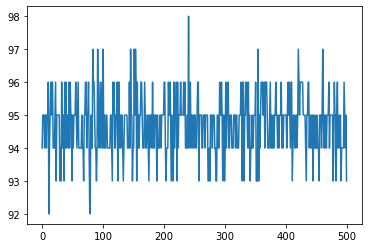

In [80]:
plt.plot(test[:,0])